In [1]:
import sys
import json
import csv
import yaml
import os

# can use the following as alternative way to load a large
#    set of environment variables; see below
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

C:\Users\l2667\AppData\Local\Temp\ipykernel_11336\282696091.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# to add to the end of graph title
load_dotenv()

firstname = os.environ['firstname']
lastname = os.environ['lastname']
l4ID = os.environ['l4ID']

In [3]:
# Load JSON data from the file
with open("update_datetimes_query.json", 'r') as file:
    data = json.load(file)

# Printing the loaded file
print(json.dumps(data, indent=4, sort_keys=True))

{
    "update_datetimes_query_Bedford-Stuyvesant": {
        "__": {
            "avg": 6.9483,
            "count": 50,
            "max": 9.9038,
            "min": 4.9783,
            "std": 1.4342,
            "timestamp": "2025-05-17-05:01:17"
        },
        "__datetime_in_reviews__": {
            "avg": 6.4764,
            "count": 50,
            "max": 11.5047,
            "min": 4.971,
            "std": 1.5453,
            "timestamp": "2025-05-17-05:12:12"
        },
        "__datetime_in_reviews__neigh_in_listings__": {
            "avg": 5.6463,
            "count": 50,
            "max": 9.5774,
            "min": 4.8401,
            "std": 1.1901,
            "timestamp": "2025-05-17-05:32:00"
        },
        "__neigh_in_listings__": {
            "avg": 6.2526,
            "count": 50,
            "max": 11.6292,
            "min": 4.9708,
            "std": 1.3179,
            "timestamp": "2025-05-17-05:22:43"
        }
    },
    "update_datetimes_query_Bron

### 9. Update Datetimes Query Average Values per Location

In [4]:
records = []
location_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neighbourhood_index",
    "__datetime_in_reviews__neigh_in_listings__": "datetime_and_neighbourhood_index"
}

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(records)

# rename columns by using the key_labels dictionary
loc_avg = loc_std.rename(columns=key_labels)

# set location as index
loc_avg = loc_avg.set_index("location")

print(loc_avg)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.7938          0.7057               1.7444   
Fort Hamilton         2.4823          2.6769               2.6032   
Long Island City      3.5231          3.4754               3.4814   
Bedford-Stuyvesant    6.9483          6.4764               6.2526   
Staten Island         2.9370          3.5937               3.6233   
Bronx                 4.3518          4.1495               4.3158   
Queens               14.9064         14.1570              14.1154   
Manhattan            24.4415         24.3724              23.8161   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               2.0919  
Fort Hamilton                                 2.5360  
Long Island City                              3.5333  
Bedford-Stuyvesant                

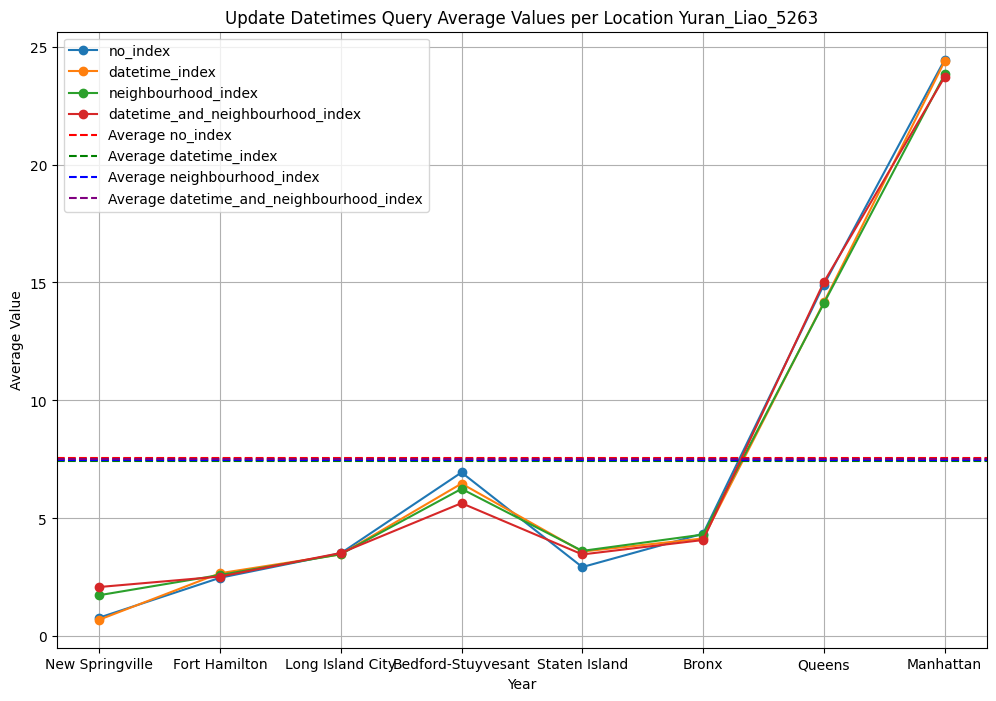

In [5]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_avg.index, loc_avg[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query Average Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 10. Update Datetimes Query STD Values per Location

In [6]:
record_std = []

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    record_std.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(record_std)

# rename columns by using the key_labels dictionary
loc_std = loc_std.rename(columns=key_labels)

# set location as index
loc_std = loc_std.set_index("location")

print(loc_std)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.6084          0.0400               0.6505   
Fort Hamilton         0.4395          0.4100               0.4451   
Long Island City      0.5684          0.5981               0.5283   
Bedford-Stuyvesant    1.4342          1.5453               1.3179   
Staten Island         0.5912          0.4280               0.4646   
Bronx                 0.4518          0.4208               0.4718   
Queens                3.0107          1.8317               3.2268   
Manhattan             6.6517          5.1987               3.8361   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               0.1383  
Fort Hamilton                                 0.3663  
Long Island City                              0.5740  
Bedford-Stuyvesant                

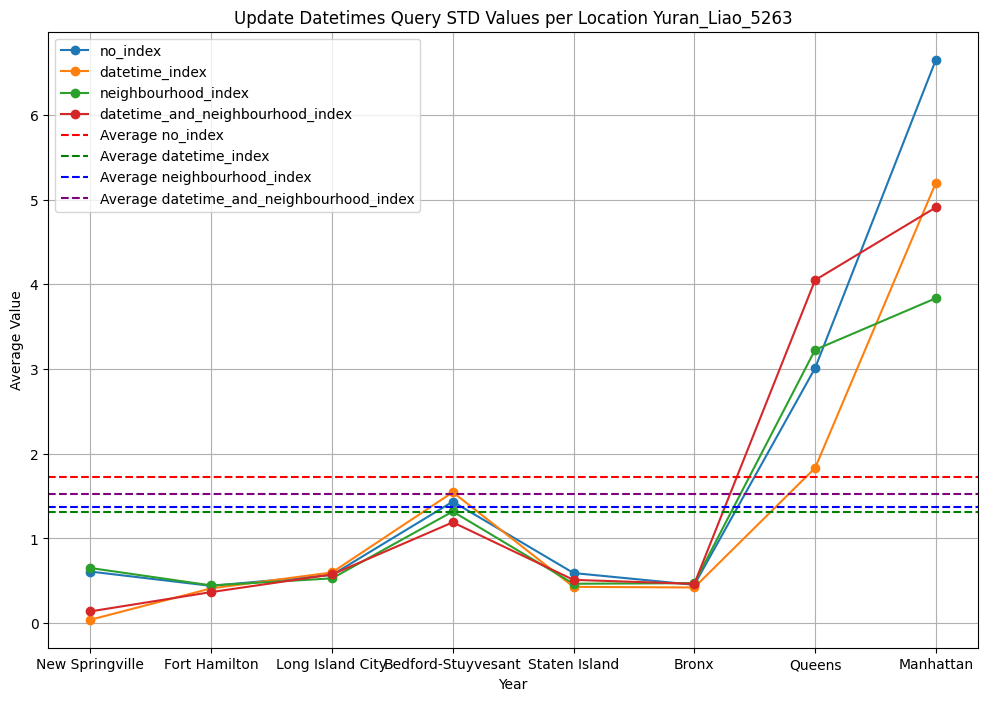

In [7]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_std.index, loc_std[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query STD Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()